In [34]:
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

def read_fluxes ():
    # Read the data file
    # Adjust the file path as needed
    data_file = 'heatflux.dat'
    # Use read_csv to read the file
    df1 = pd.read_csv(data_file, sep='\s+', header=None, names=['date', 'time', 'Q'])
    # Combine the 'date' and 'time' columns into a single 'datetime' column
    df1['datetime'] = df1['date'] + ' ' + df1['time']
    # Convert 'datetime' column to datetime format
    df1['datetime'] = pd.to_datetime(df1['datetime'], format='%Y/%m/%d %H:%M:%S')
    # Drop the separate 'date' and 'time' columns if they are no longer needed
    df1.drop(columns=['date', 'time'], inplace=True)
    # Combine the date and time columns if necessary
    # Ensure 'datetime' column is in the correct format
    df1['datetime'] = pd.to_datetime(df1['datetime'], format='%Y/%m/%d %H:%M:%S')

    data_file = 'momentumflux.dat'
    df2 = pd.read_csv(data_file, sep='\s+', header=None, names=['date', 'time', 'taux', 'tauy'])
    df2['datetime'] = df2['date'] + ' ' + df2['time']
    df2['datetime'] = pd.to_datetime(df2['datetime'], format='%Y/%m/%d %H:%M:%S')
    df2.drop(columns=['date', 'time'], inplace=True)
    df2['datetime'] = pd.to_datetime(df2['datetime'], format='%Y/%m/%d %H:%M:%S')

    df = pd.merge(df1, df2, on='datetime')
    df = df[['datetime','Q','taux','tauy']]
    
    xrdf = xr.Dataset(
    {'taux': (['t'], df.taux),
    'tauy': (['t'], df.tauy),
    'Q': (['t'], df.Q)},
    coords={
        "t": df.datetime,
    },)
    
    return xrdf

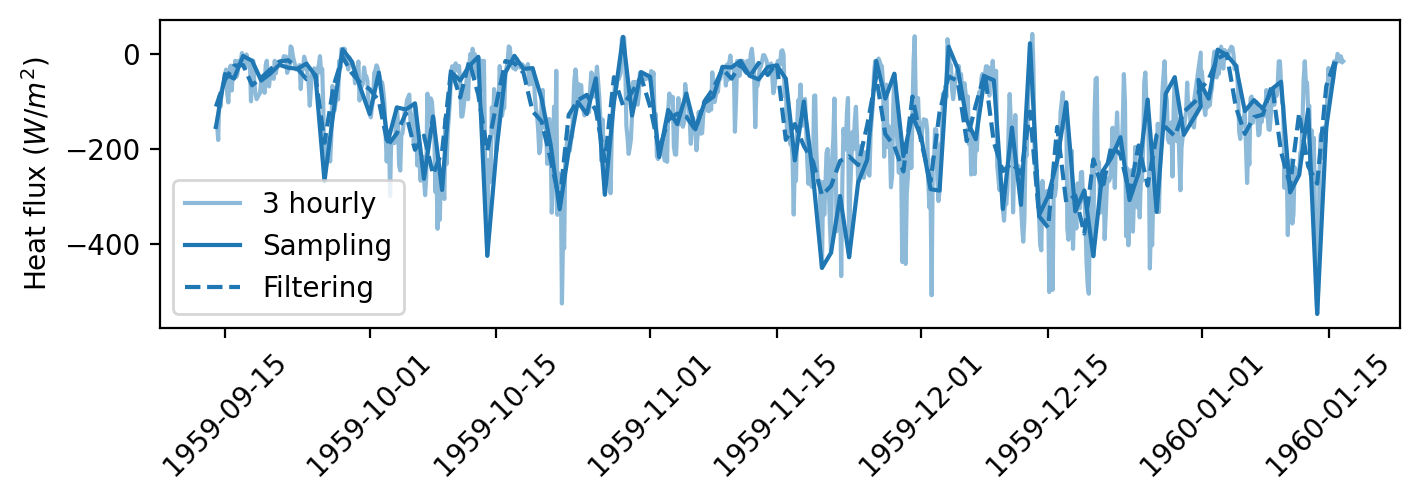

In [2]:
from io import StringIO
import numpy as np
import xarray as xr

def make_ds(filename):
    ''' Read in output and turn into 2D field. '''
    with open(filename, 'r') as file:
        lines = file.readlines()
        
    # Exclude the last two lines
    lines_to_keep = lines[:-2]
    # Join valid lines into a single string with newline characters
    valid_data = "\n".join(lines_to_keep)
    df = pd.read_csv(StringIO(valid_data), sep='\s+', header=None, names=['t','z','ux','uy','T','S','nn','nu'])
    
    # By default, reshape uses row-major (C-style) order, meaning it fills the array row by row.
    n1 = 731 # number of time steps
    n2 = 250 # number of depth
    time = df['t'][::n2]/3600. # output is every 12 hrs (from second to hour)
    depth = df['z'][:n2] # depth are 1 m apart

    ux_2D = np.reshape(df['ux'],(n1,n2))
    uy_2D = np.reshape(df['uy'],(n1,n2))
    T = np.reshape(df['T'],(n1,n2))
    S = np.reshape(df['S'],(n1,n2))

    xrdf = xr.Dataset(
        {'ux': (['t','z'], ux_2D),
        'uy': (['t','z'], uy_2D),
        'T': (['t','z'], T),
        'S': (['t','z'], S)},
        coords={
            "t": time,
            "z": depth
        },)
    
    return xrdf

In [63]:
24*365

8760

Text(0.5, 1.0, 'KPP minus $k-\\epsilon$')

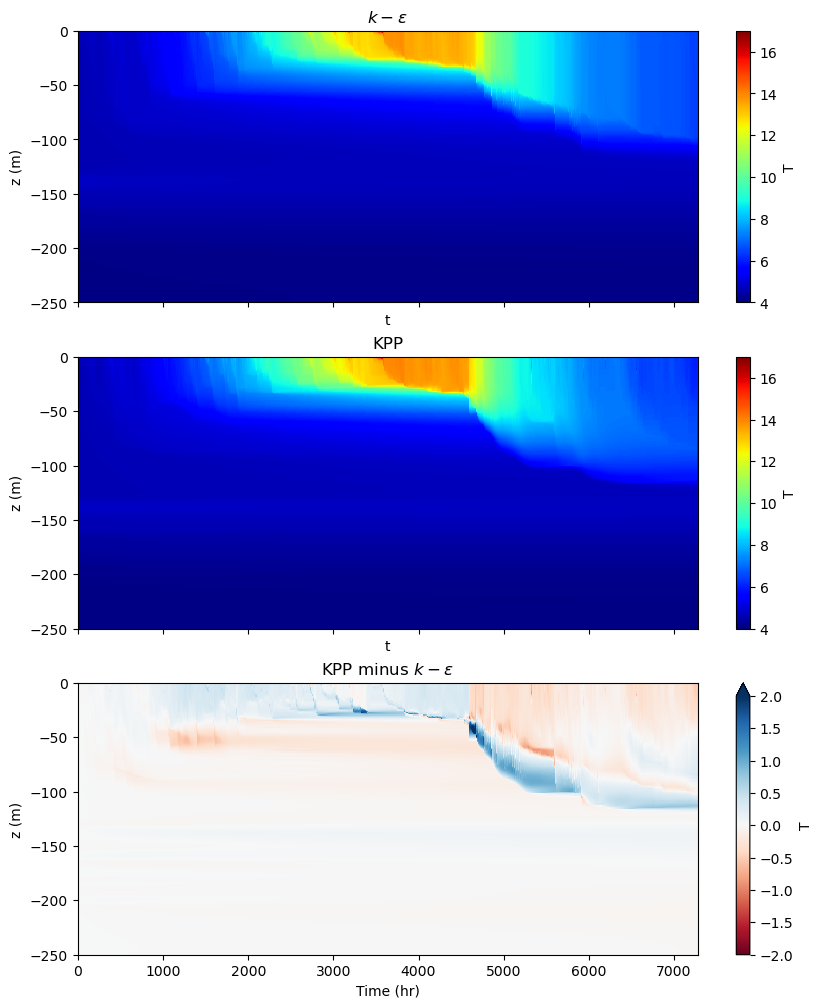

In [5]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,12], sharex=True)

df1 = make_ds('out')
df1['T'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[0].set_ylabel('z (m)')
axes[0].set_title(r'$k-\epsilon$')

df2 = make_ds('out_kpp')
df2['T'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[1].set_ylabel('z (m)')
axes[1].set_title('KPP')

(df2['T']-df1['T']).plot.pcolormesh(ax=axes[2], x='t',y='z', vmin=-2, vmax=2, cmap='RdBu')
axes[2].set_ylabel('z (m)')
axes[2].set_xlabel('Time (hr)'); 
axes[2].set_title(r'KPP minus $k-\epsilon$')


In [16]:
df2_Tinterp = df2['T'].interp(t=df1.t, z=df1.z)
df2_Tinterp

<xarray.DataArray 'T' (t: 731, z: 250)>
array([[4.1       , 4.1       , 4.1       , ..., 4.6       , 4.6       ,
        4.6       ],
       [4.1       , 4.1       , 4.1       , ..., 4.56416   , 4.56206   ,
        4.5581    ],
       [4.1       , 4.1       , 4.1       , ..., 4.61186   , 4.61358   ,
        4.61631   ],
       ...,
       [4.1005    , 4.10052917, 4.10058   , ..., 6.32685917, 6.32922833,
        6.33299833],
       [4.1005    , 4.10053   , 4.10058917, ..., 6.23308167, 6.22882   ,
        6.22065583],
       [4.1005    , 4.10053   , 4.10059   , ..., 6.22383667, 6.22296   ,
        6.22087167]])
Coordinates:
  * t        (t) float64 0.0 12.0 24.0 36.0 ... 8.734e+03 8.746e+03 8.758e+03
  * z        (z) float64 -249.5 -248.5 -247.5 -246.5 ... -3.5 -2.5 -1.5 -0.5

Text(0.5, 1.0, 'Daily minus 3-hourly')

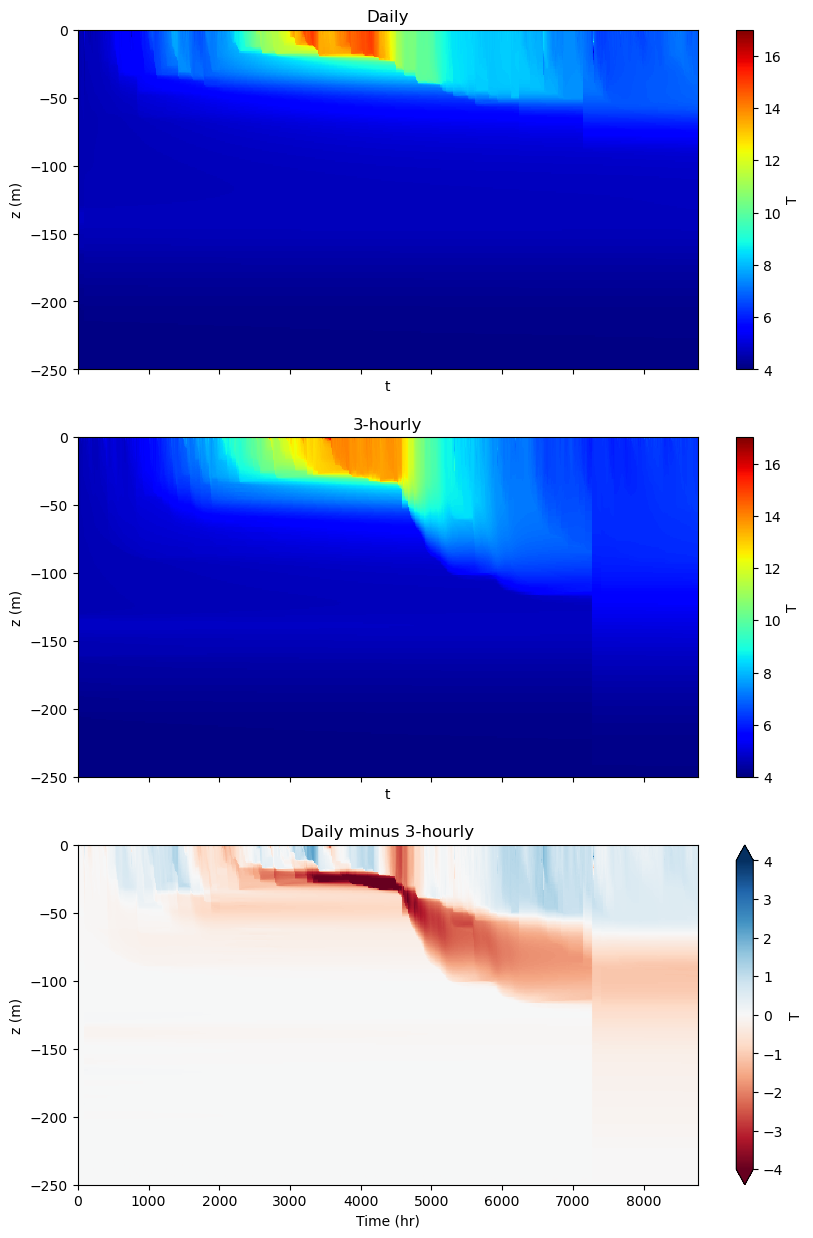

In [60]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,15], sharex=True)

df1 = make_ds('out_kpp_daily')
df1['T'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[0].set_ylabel('z (m)')
axes[0].set_title(r'Daily')
# axes[0].set_xlim([0,4000])

df2 = make_ds('out_kpp')
df2['T'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[1].set_ylabel('z (m)')
axes[1].set_title('3-hourly')
# axes[1].set_xlim([0,4000])

df2_Tinterp = df2['T'].interp(t=df1.t, z=df1.z)
diff = df1['T']-df2_Tinterp
diff.plot.pcolormesh(ax=axes[2], x='t', y='z', vmin=-4, vmax=4, cmap='RdBu')
axes[2].set_ylabel('z (m)')
axes[2].set_xlabel('Time (hr)'); 
axes[2].set_title(r'Daily minus 3-hourly')
# axes[2].set_xlim([0,4000])

Text(0.5, 1.0, '3-hourly minus daily')

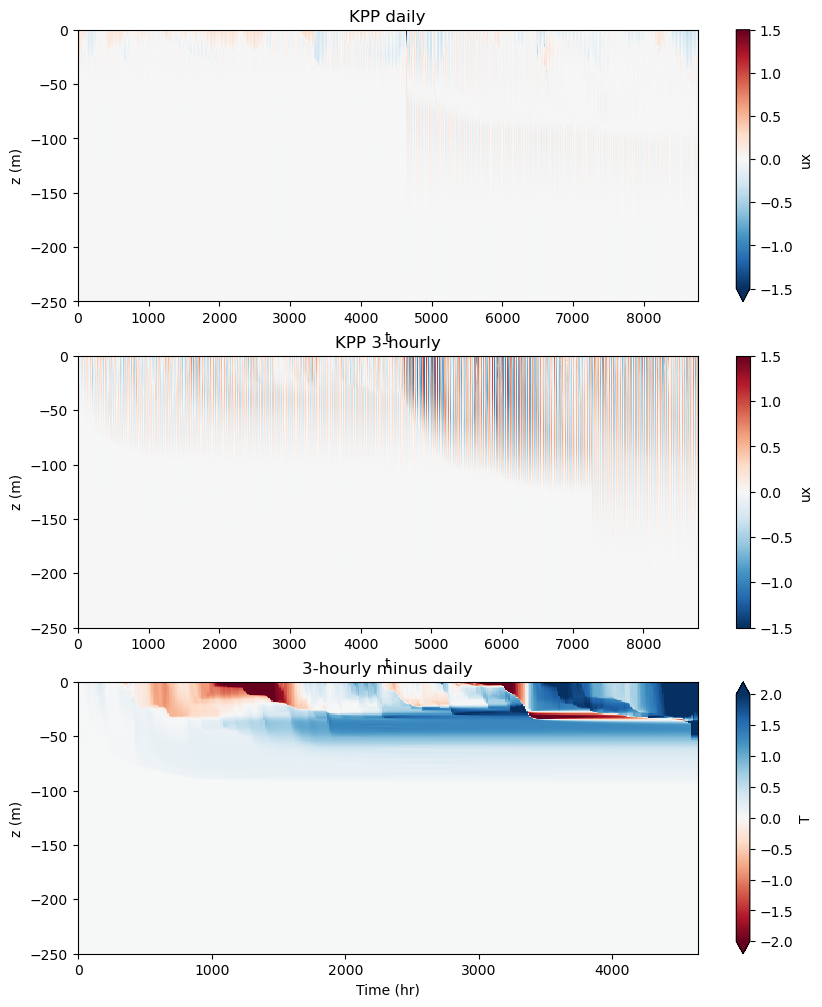

In [159]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,12])

df1 = make_ds('out_kpp_daily')
df1['ux'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmax=1.5, vmin=-1.5, cmap='RdBu_r')
axes[0].set_ylabel('z (m)')
axes[0].set_title('KPP daily')

df2 = make_ds('out_kpp')
df2['ux'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmax=1.5, vmin=-1.5, cmap='RdBu_r')
axes[1].set_ylabel('z (m)')
axes[1].set_title('KPP 3-hourly')

(df2['T']-df1['T']).plot.pcolormesh(ax=axes[2], x='t',y='z', vmin=-2, vmax=2, cmap='RdBu')
axes[2].set_ylabel('z (m)')
axes[2].set_xlabel('Time (hr)'); 
axes[2].set_title(r'3-hourly minus daily')


In [189]:
with open('out_kpp_daily', 'r') as file:
    lines = file.readlines()
    
# Exclude the last two lines
lines_to_keep = lines[:-2]
# Join valid lines into a single string with newline characters
valid_data = "\n".join(lines_to_keep)
df = pd.read_csv(StringIO(valid_data), sep='\s+', header=None, names=['t','z','ux','uy','T','S','nn','nu'])

# By default, reshape uses row-major (C-style) order, meaning it fills the array row by row.
n1 = 731 # number of time steps
n2 = 250 # number of depth
time = df['t'][::n2]/3600. # output is every 12 hrs (from second to hour)
depth = df['z'][:n2] # depth are 1 m apart

ux_2D = np.reshape(df['ux'],(n1,n2))
uy_2D = np.reshape(df['uy'],(n1,n2))
T = np.reshape(df['T'],(n1,n2))
S = np.reshape(df['S'],(n1,n2))

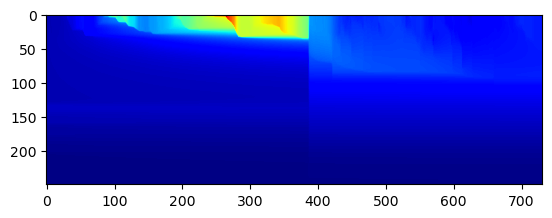

In [193]:
plt.imshow(np.rot90(T), vmin=4, vmax=17, cmap='jet')